# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
We are attempting to predict the climate category (cold, neutral, warm) in which an outage occurs based on data regarding the outage itself and the location in which it occured. This is a classification problem with 3 possible classifications. The evaluation metric of our model will be its accuracy in predicting the climate category, objective is to reach a 70% accuracy in our model.

### Baseline Model
Features:
- Quantitative: 3  
`AREAPCT_URBAN`, `OUTAGE.DURATION`, `CUSTOMERS.AFFECTED`  
- Nominal: 4  
`U.S._STATE`, `CLIMATE.REGION`, `CAUSE.CATEGORY`, `MONTH`  

Performance:
- Accuracy: 0.65  
- Accuracy is the best metric for our purposes as we only care about our models correctness in prediction

### Final Model  
Added Features:  
1. Added an engineered region feature according to the State in which the outage occured in order to provide more generalizable classifications of weather conditions   
2. Added Population and Population Density of Urban Areas as these can coorrelate to certain type of cities, namely warmer cities leading to better predictions of weather categories   
3. Binarize customers affected based on the median amount due to its high standard deviation.

Features:
- Quantitative: 5  
`AREAPCT_URBAN`, `POPDEN_URBAN`, `POPULATION`,`OUTAGE.DURATION`, `CUSTOMERS.AFFECTED`
- Nominal: 4 
`U.S._STATE`, `CLIMATE.REGION`, `CAUSE.CATEGORY`, `MONTH`

Model Type: 
- `RandomForestClassifier()`   

Parameters:
- `{criterion= 'entropy', max_depth=260, max_features='auto'}`

Performance:
- Accuracy: 0.71

### Fairness Evaluation  
Our fairness evaluation concerns the region in which an outage occurs to ensure that all unique parts of the country are equally represented in our classification in terms of its accuracy
- Null Hypothesis: The classifier's accuracy is the same across regions
- Alternative Hypothesis: The classifier's accuracy is different across regions

Test statistic: Absolute Difference in accuracy between regions   
Significance level: 0.01  
Outcome: 0.56 (Fail to reject the null)

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Binarizer
import warnings
warnings.simplefilter('ignore')

### Data Set 

In [3]:
# importing the excel file
data = pd.read_excel('outage.xlsx') 
data = data[4:].reset_index(drop=True)

#renaming the column names to match the excel sheet
data.columns = data.iloc[0]

# dropping unneccesary columns
data = data.drop([0]).drop([1]).drop(columns = ['variables', 'OBS', 'YEAR']).reset_index(drop=True)

# DataFrame
data.head()

,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


### Baseline Model

With the `OUTAGES` dataset, the features that were most prevalent in determining the `CLIMATE.CATEGORY` were:  
`AREAPCT_URBAN`, 
`POPULATION`,
`OUTAGE.DURATION`,
`CUSTOMERS.AFFECTED`,
`NERC.REGION`,
`CLIMATE.REGION`,
`CAUSE.CATEGORY`,
`MONTH`,
`U.S._STATE`.

In [4]:
data = data.dropna(how='any', subset=['CLIMATE.CATEGORY'])
data[['POPULATION', 'AREAPCT_URBAN', 'TOTAL.PRICE', 'CUSTOMERS.AFFECTED']] = data[['POPULATION', 
                                                                                   'AREAPCT_URBAN', 'TOTAL.PRICE', 
                                                                                   'CUSTOMERS.AFFECTED']].fillna(0)
data[['NERC.REGION', 'CLIMATE.REGION', 'CAUSE.CATEGORY']] = data[['NERC.REGION',
                                                                  'CLIMATE.REGION', 
                                                                  'CAUSE.CATEGORY']].fillna('missing')
data['OUTAGE.DURATION'] = data['OUTAGE.DURATION'].fillna(0)

In [5]:
preproc = ColumnTransformer(
        transformers=[
            ('as is', FunctionTransformer(), ['AREAPCT_URBAN', 'OUTAGE.DURATION', 
                                              'CUSTOMERS.AFFECTED']),
            ('ohe', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 
                                                             'CLIMATE.REGION', 'CAUSE.CATEGORY', 
                                                             'MONTH'])
        ]
    )

base_pl = Pipeline([
        ('preprocessing', preproc),
        ('f', RandomForestClassifier())
    ])

In [6]:
features = data.drop('CLIMATE.CATEGORY', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features,
                                                        data['CLIMATE.CATEGORY'],
                                                        test_size=0.3)
base_pl.fit(X_train, y_train)
base_pl.score(X_test, y_test)

0.6572052401746725

### Final Model

In [7]:
# importing the excel file
data = pd.read_excel('outage.xlsx') 
data = data[4:].reset_index(drop=True)

#renaming the column names to match the excel sheet
data.columns = data.iloc[0]

# dropping unneccesary columns
data = data.drop([0]).drop([1]).drop(columns = ['variables', 'OBS', 'YEAR']).reset_index(drop=True)

# DataFrame
data.head()

data = data.dropna(how='any', subset=['CLIMATE.CATEGORY'])
data[['POPULATION', 'AREAPCT_URBAN', 'TOTAL.PRICE', 'CUSTOMERS.AFFECTED']] = data[['POPULATION',
                                                                                   'AREAPCT_URBAN',
                                                                                   'TOTAL.PRICE', 
                                                                                   'CUSTOMERS.AFFECTED']].fillna(0)
data[['NERC.REGION', 'CLIMATE.REGION', 'CAUSE.CATEGORY']] = data[['NERC.REGION', 'CLIMATE.REGION',
                                                                  'CAUSE.CATEGORY']].fillna('missing')
data['OUTAGE.DURATION'] = data['OUTAGE.DURATION'].fillna(0)

With the states, we found the correlating region that they are in. This was created in order to generalized classification conditions.

In [8]:
states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest'}

Changed `U.S._STATE` from state names into regions.

In [9]:
data = data.dropna(how='any', subset=['CLIMATE.CATEGORY'])
data['U.S._STATE'] = data['U.S._STATE'].apply(lambda s: states_to_regions[s])
features = data.drop('CLIMATE.CATEGORY', axis=1)

In [10]:
data.head()

,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,7,Midwest,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,2011-07-03 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,5,Midwest,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,10,Midwest,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,2010-10-28 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,6,Midwest,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,2012-06-20 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,7,Midwest,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,2015-07-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


Binarized `CUSTOMERS.AFFECTED` since the spread was high. We created a threadhold of `7000` because we found that it was the median number of customers affected. 

We also made a `FunctionTransformer` to log all the `OUTAGE.DURATION` values because the range was large for different purposes and the `DURATION` feature  was not a significant feature to weigh.

In [11]:
preproc2 = ColumnTransformer(
        transformers=[
            ('as is', FunctionTransformer(), ['AREAPCT_URBAN', 'POPDEN_URBAN', 
                                              'POPULATION']),
            ('log scale', FunctionTransformer(lambda ser: (ser + 0.1).apply(np.log)), ['OUTAGE.DURATION']),
            ('bin', Binarizer(threshold=7000), ['CUSTOMERS.AFFECTED']),
            ('ohe', OneHotEncoder(handle_unknown='ignore'), ['CLIMATE.REGION', 
                                                             'CAUSE.CATEGORY', 'MONTH', 'U.S._STATE'])
        ]
    )

pl = Pipeline([
        ('preprocessing', preproc2),
        ('f', RandomForestClassifier())
    ])

We ran a `GridSearch` in order to find the best hyperparameters for `RandomForestClassifier`

In [12]:
hyperparameters = { 
    'f__max_depth' : np.arange(200, 400, 20),
    'f__criterion' :['gini', 'entropy']
}

In [13]:
searcher = GridSearchCV(pl, param_grid = hyperparameters, cv=5)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                        data['CLIMATE.CATEGORY'],
                                                        test_size=0.3)
searcher.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('as '
                                                                         'is',
                                                                         FunctionTransformer(),
                                                                         ['AREAPCT_URBAN',
                                                                          'POPDEN_URBAN',
                                                                          'POPULATION']),
                                                                        ('log '
                                                                         'scale',
                                                                         FunctionTransformer(func=<function <lambda> at 0x0000025156775A60>),
                                                                         ['OUTAGE.DURATION']),


In [15]:
searcher.best_params_

{'f__criterion': 'entropy', 'f__max_depth': 260}

The final pipeline with the best hyperparameters.

In [25]:
final_pl = Pipeline([
        ('preprocessing', preproc2),
        ('f', RandomForestClassifier(criterion= 'entropy', max_depth=260, max_features='auto'))
    ])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                        data['CLIMATE.CATEGORY'],
                                                        test_size=0.3)
final_pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('as is',
                                                  FunctionTransformer(),
                                                  ['AREAPCT_URBAN',
                                                   'POPDEN_URBAN',
                                                   'POPULATION']),
                                                 ('log scale',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000025156775A60>),
                                                  ['OUTAGE.DURATION']),
                                                 ('bin',
                                                  Binarizer(threshold=7000),
                                                  ['CUSTOMERS.AFFECTED']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                      

In [27]:
final_pl.score(X_test, y_test)

0.7096069868995634

### Fairness Evaluation

In [19]:
import sklearn.metrics as metrics

In [20]:
results = X_test
results['prediction'] = final_pl.predict(X_test)
results['tag'] = y_test

In [21]:
results

,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,prediction,tag
789,6,Northeast,NJ,RFC,Northeast,-0.5,2008-06-09 00:00:00,14:52:00,2008-06-09 00:00:00,20:25:00,...,2851.2,1446.5,105.5,39.70,2.01,84.305858,15.682678,4.99828,cold,cold
63,3,Midwest,WI,MRO,East North Central,-0.4,2014-03-04 00:00:00,09:06:00,2014-03-17 00:00:00,09:06:00,...,2123.3,1671.5,32.5,3.47,0.9,82.689019,17.312508,3.049041,normal,normal
813,1,South,SC,SERC,Southeast,-0.5,2014-01-07 00:00:00,18:00:00,2014-01-07 00:00:00,23:00:00,...,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923,normal,cold
661,12,West,UT,WECC,Southwest,-0.3,2013-12-06 00:00:00,08:47:00,2013-12-06 00:00:00,08:49:00,...,2737.1,1611.2,3.2,1.11,0.2,96.787872,3.212128,3.212128,normal,normal
1107,5,West,CA,WECC,West,-0.2,2007-05-14 00:00:00,11:15:00,2007-05-14 00:00:00,13:50:00,...,4303.7,2124.1,12.7,5.28,0.59,95.164177,4.835823,1.730658,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,7,South,MD,RFC,Northeast,-0.9,2010-07-25 00:00:00,15:20:00,2010-07-27 00:00:00,18:00:00,...,2511.4,1291.8,96,20.65,1.69,78.244398,21.755602,6.190553,normal,cold
1245,10,West,CA,WECC,West,-1.1,2007-10-22 00:00:00,14:05:00,2007-10-22 00:00:00,14:22:00,...,4303.7,2124.1,12.7,5.28,0.59,95.164177,4.835823,1.730658,cold,cold
1433,1,Northeast,MA,NPCC,Northeast,-1.3,2011-01-12 00:00:00,06:00:00,2011-01-12 00:00:00,14:00:00,...,2016.3,1194.5,109.2,38.29,1.17,73.905628,26.094372,4.604889,normal,cold
413,7,West,WA,WECC,Northwest,1.2,2015-07-21 00:00:00,12:47:00,2015-07-21 00:00:00,13:12:00,...,2380,1487.9,16.7,3.57,0.62,93.208786,6.791214,2.405397,normal,warm


Ran a permutation test based on accuracy.

In [22]:
obs = results.groupby('CLIMATE.REGION').apply(lambda x: metrics.accuracy_score(x['tag'], 
                                                                               x['prediction'])).diff().iloc[-1]
diff_in_acc = []
for _ in range(100):
    df = results[['CLIMATE.REGION', 'prediction', 'tag']]
    df['CLIMATE.REGION'] = results['CLIMATE.REGION'].sample(frac=1.0,
                                                            replace=False).reset_index(drop=True)
    out = df.groupby('CLIMATE.REGION').apply(lambda x: metrics.accuracy_score(x['tag'], x['prediction'])).diff().iloc[-1]
    diff_in_acc.append(abs(out))

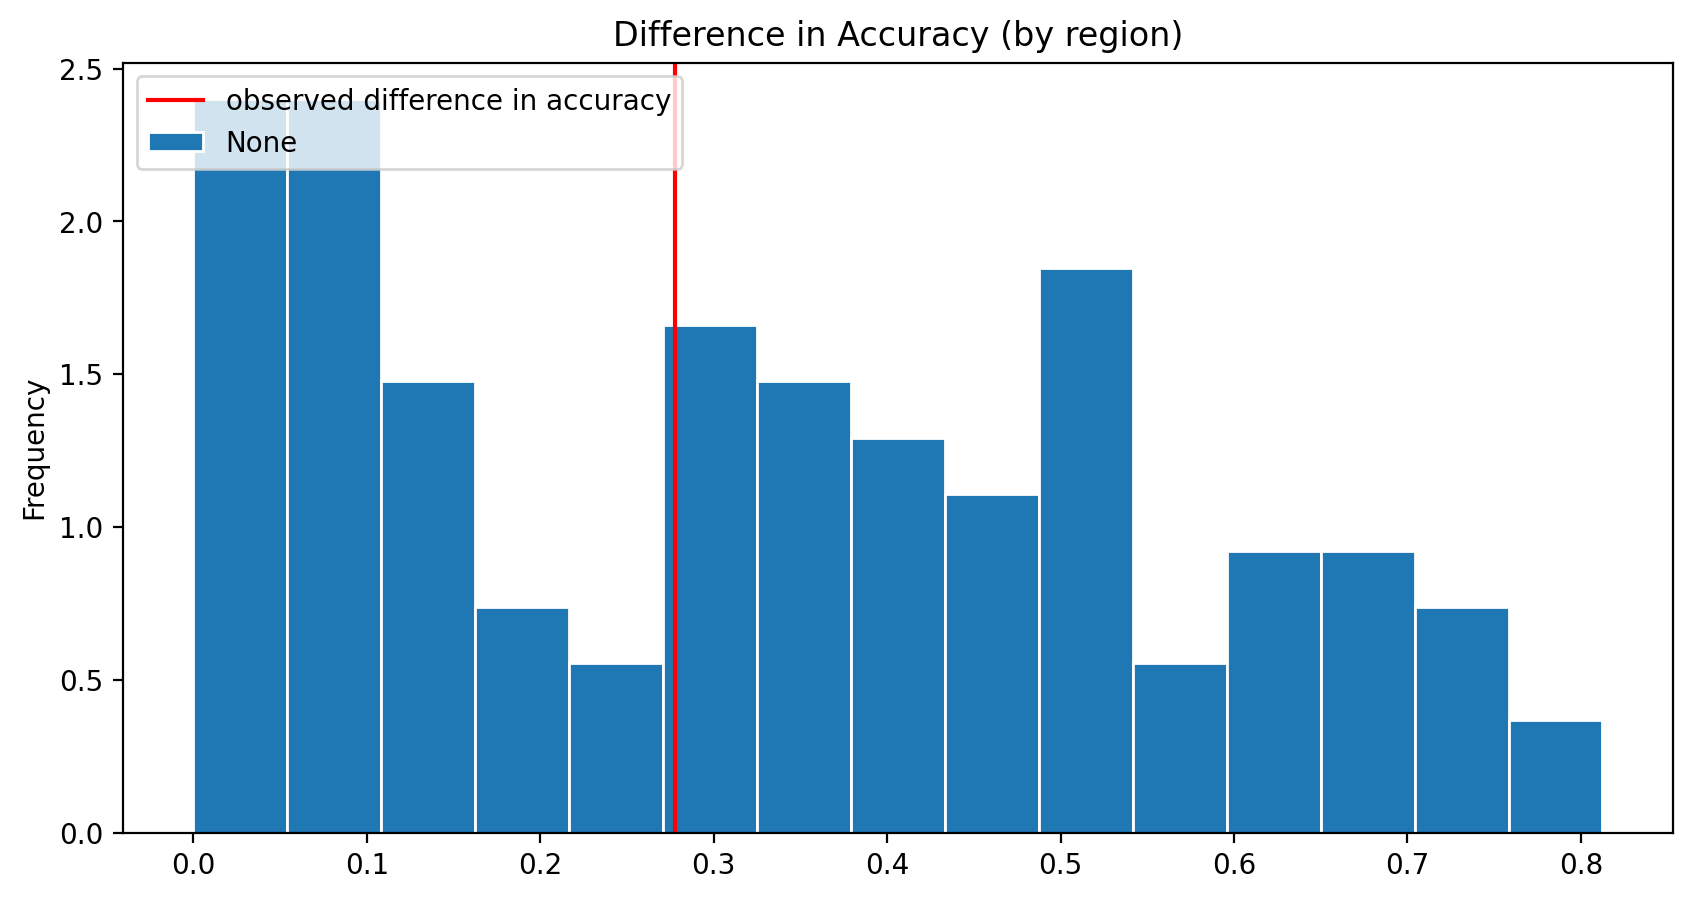

In [23]:
plt.figure(figsize=(10, 5))
pd.Series(diff_in_acc).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy (by region)')
plt.axvline(x=abs(obs), color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');

In [24]:
p_val = (np.array(diff_in_acc) >= abs(obs)).mean()
p_val

0.58